# SET UP

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from models import * 
from utils import * 

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

# EDA 

In [2]:
ID = '06DA002'
ClimateID = '1128958'
!wget https://dd.weather.gc.ca/hydrometric/csv/MB/daily/MB_05TD001_daily_hydrometric.csv
hydro = pd.read_csv('./MB_05TD001_daily_hydrometric.csv')

wget: /raid/apps/jupyter/1.0.0/lib/libuuid.so.1: no version information available (required by wget)
--2020-11-13 07:06:54--  https://dd.weather.gc.ca/hydrometric/csv/MB/daily/MB_05TD001_daily_hydrometric.csv
Resolving dd.weather.gc.ca (dd.weather.gc.ca)... 205.189.10.47
Connecting to dd.weather.gc.ca (dd.weather.gc.ca)|205.189.10.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 472087 (461K) [text/csv]
Saving to: ‘MB_05TD001_daily_hydrometric.csv’

MB_05TD001_daily_hy 100%[===================>] 461,02K   549KB/s    in 0,8s    

2020-11-13 07:06:56 (549 KB/s) - ‘MB_05TD001_daily_hydrometric.csv’ saved [472087/472087]



In [3]:
hydro.drop(hydro[hydro["Water Level / Niveau d'eau (m)"]==99999.009].index , inplace =True ) 
hydro["Water Level"] = hydro["Water Level / Niveau d'eau (m)"]
hydro["Date"] = pd.to_datetime(hydro["Date"])
hydro = hydro[["Date","Water Level"]]

## Stationarity 

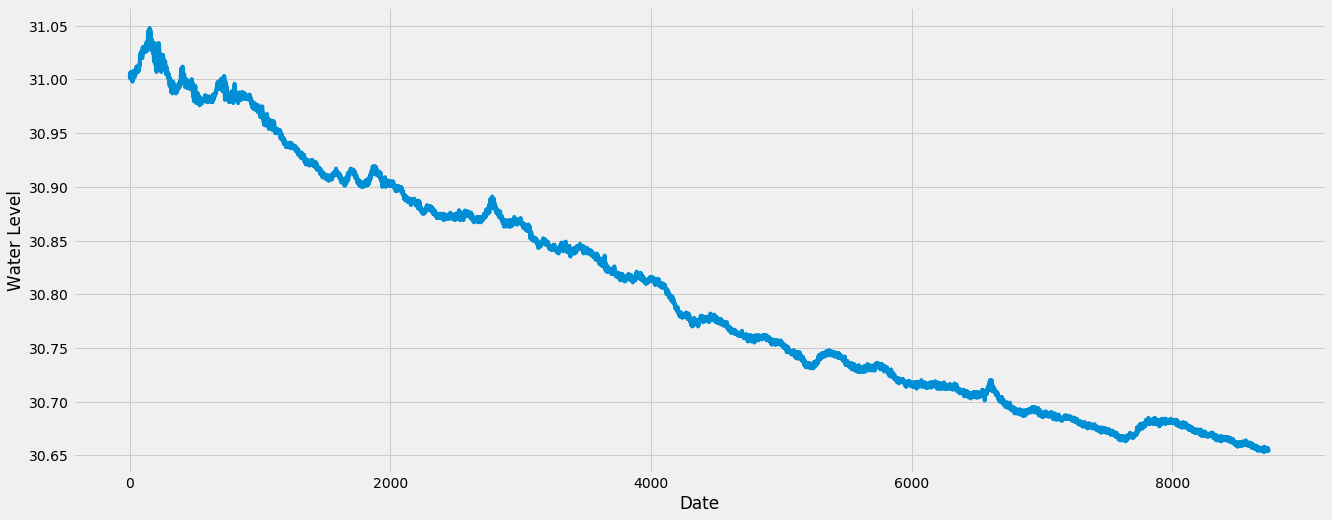

In [4]:
plt.xlabel("Date")
plt.ylabel("Water Level")
plt.plot(hydro["Water Level"])
plt.show()

in the time series forecasting, we search usually for a stationary series. The series should have a constant mean, variance, and covariance.

so let's check if the  Water Level series is stationary or not. to do this i will use ADF (Augmented Dickey-Fuller) Test :

* Null Hypothesis: The series has a unit root
* Alternate Hypothesis: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary.

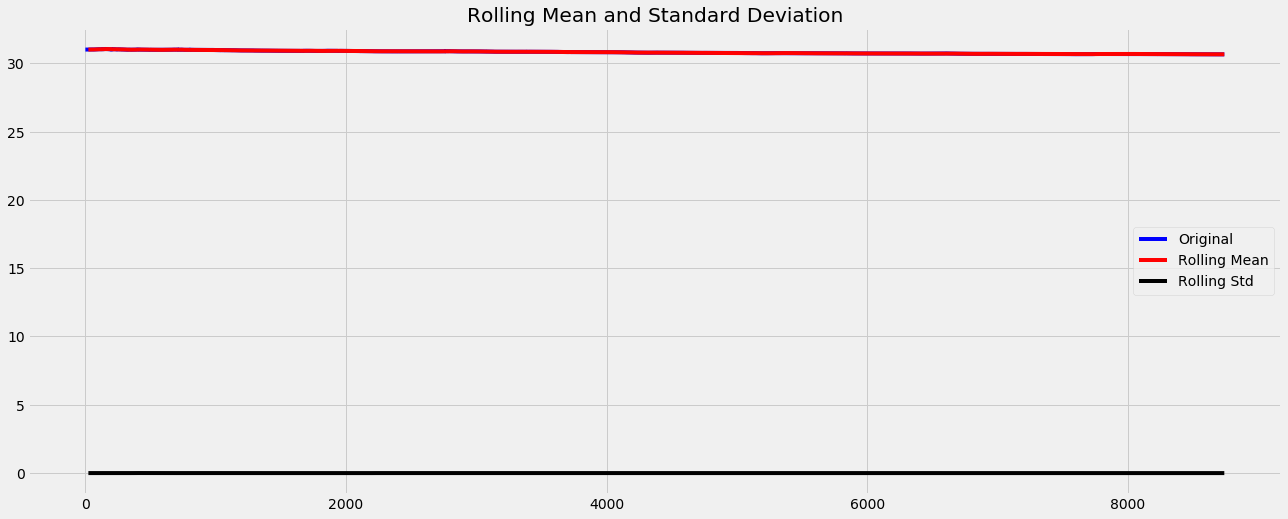

Results of dickey fuller test
Test Statistics                  -1.518328
p-value                           0.524426
No. of lags used                 27.000000
Number of observations used    8712.000000
critical value (1%)              -3.431101
critical value (5%)              -2.861872
critical value (10%)             -2.566947
dtype: float64


In [5]:
test_stationarity(hydro["Water Level"])

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

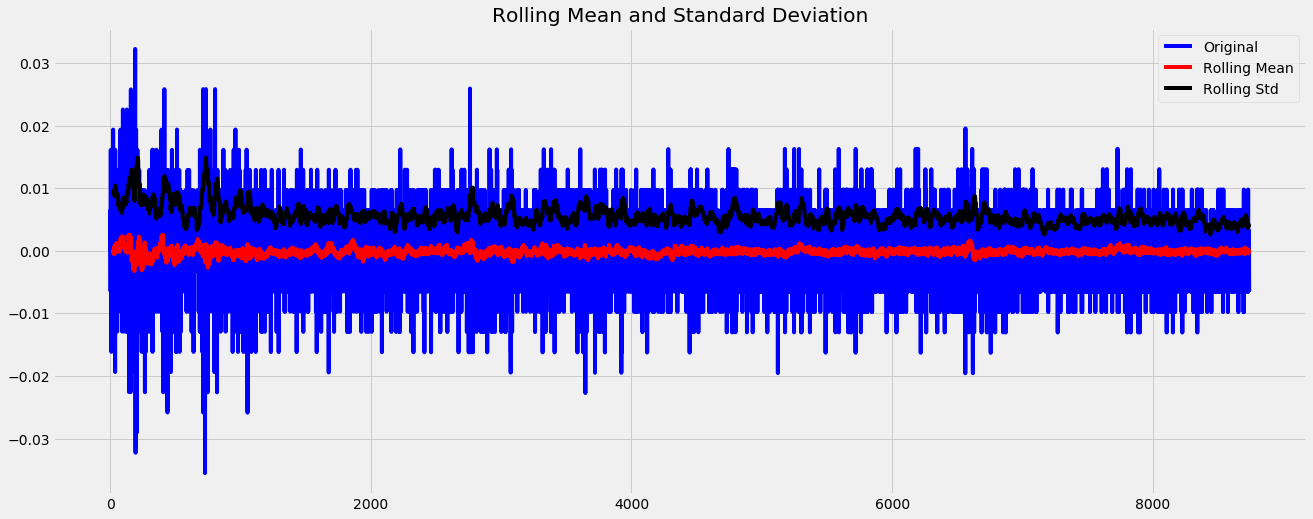

Results of dickey fuller test
Test Statistics               -1.744510e+01
p-value                        4.686084e-30
No. of lags used               2.600000e+01
Number of observations used    8.712000e+03
critical value (1%)           -3.431101e+00
critical value (5%)           -2.861872e+00
critical value (10%)          -2.566947e+00
dtype: float64


In [6]:
hydro['Water Level_previous'] = hydro["Water Level"].shift(1) 
hydro['WL_pct'] = 100*(hydro["Water Level"]  - hydro['Water Level_previous'] ) / hydro['Water Level_previous']
hydro.dropna(inplace = True)
test_stationarity(hydro['WL_pct'])

Through the above graph,The series have a constant mean and variance. and the p-value is less than 0.05 so we can reject the Null hypothesis. so the data is stationary.

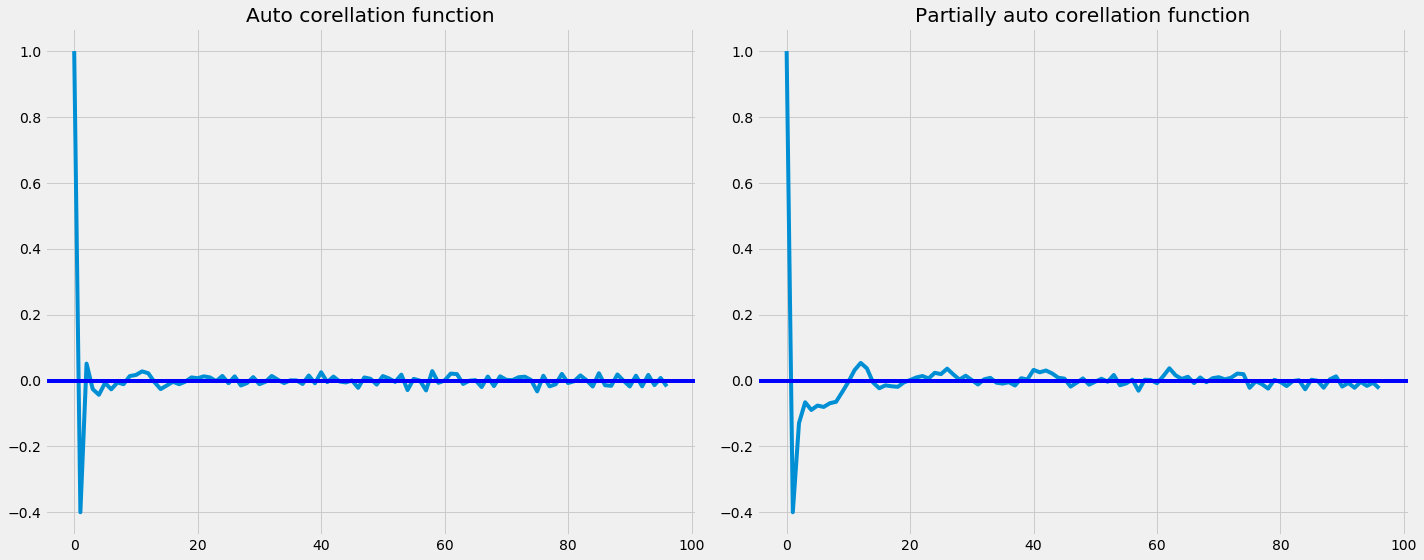

In [7]:
# we use d value here(data_log_shift)
_acf = acf(hydro['WL_pct'], nlags=96)
_pacf= pacf(hydro['WL_pct'], nlags=96,method='ols')
#plot PACF
plt.subplot(121)
plt.plot(_acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.title('Auto corellation function')
plt.tight_layout()
#plot ACF
plt.subplot(122)
plt.plot(_pacf) 
plt.axhline(y=0,linestyle='-',color='blue')

plt.title('Partially auto corellation function')
plt.tight_layout()

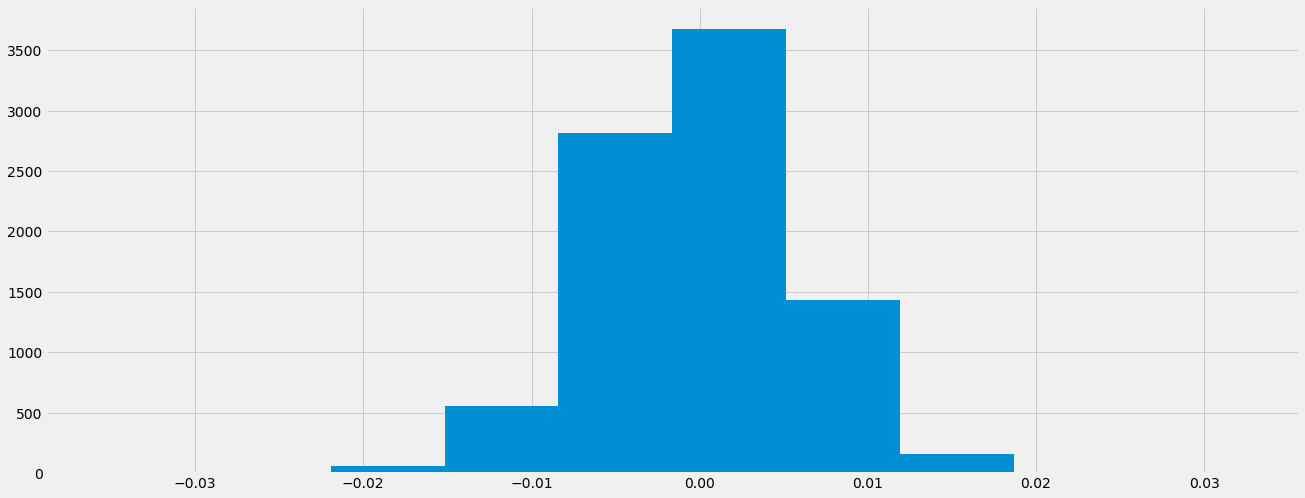

In [8]:
hydro['WL_pct'].hist()

## To Do:  multivarite Time Series Analysis

# To Do : Data Denoising

# Feature Engineering

## Statistical Features 

In [9]:
hydro['WL_mean_12'] = hydro['WL_pct'].rolling(12).mean()
hydro['WL_mean_18'] = hydro['WL_pct'].rolling(18).mean()
hydro['WL_mean_24'] = hydro['WL_pct'].rolling(24).mean()

hydro['WL_std_12']  = hydro['WL_pct'].rolling(12).std()
hydro['WL_std_24']  = hydro['WL_pct'].rolling(24).std()

hydro['WL_lag_12']  = hydro['WL_pct'].shift(12)
hydro['WL_lag_6']  = hydro['WL_pct'].shift(6)

hydro.dropna(inplace = True )

In [10]:
num_feat = ['WL_pct','WL_mean_12','WL_mean_18','WL_mean_18','WL_mean_24','WL_std_12','WL_std_24','WL_lag_12','WL_lag_6']

## Time Based Features 

In [11]:
hydro['hour'] = hydro['Date'].dt.hour
hydro['dayOfweek'] =  hydro['Date'].dt.dayofweek

In [12]:
cat_feat = ['hour','dayOfweek']

In [13]:
embbedded_size  = [(24,12),(7,4)]

# Modling Part 

In [14]:
seq_len = len(hydro)
train_data = hydro.iloc[:int(0.8*seq_len)] 
val_data = hydro.iloc[int(0.8*seq_len):] 

## Model 1 :  Stacked LSTM 

In [15]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Staked.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

stacked_lstm = StackedLSTMs(input_size,hidden_size)
stacked_lstm = stacked_lstm.to(device)
val_loss, train_loss = run(
    stacked_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose 
)

--------- Epoch 0 ---------
 train_loss  = 0.00187734154371706
 val_loss  = 4.4055022600433505e-05
--------- Epoch 10 ---------
 train_loss  = 2.9889849500233732e-05
 val_loss  = 1.7581874283644504e-05
--------- Epoch 20 ---------
 train_loss  = 2.895544869490817e-05
 val_loss  = 1.730604430947467e-05
--------- Epoch 30 ---------
 train_loss  = 2.7987415593221876e-05
 val_loss  = 1.683197169936816e-05
--------- Epoch 40 ---------
 train_loss  = 2.7889375677317597e-05
 val_loss  = 1.6673122196927444e-05
Eraly Stopping on Epoch 40
Best Loss =  1.666813608591366e-05


# Model 2 : ConvLSTM

In [ ]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cuda')
window_size = 24  
path = 'ConvLSTM.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

conv_lstm = ConvLSTM(input_size,hidden_size)
conv_lstm = conv_lstm.to(device)
val_loss, train_loss = run(
    conv_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose 
)

--------- Epoch 0 ---------
 train_loss  = 0.004115329108780641
 val_loss  = 0.0002498012434578548
--------- Epoch 10 ---------
 train_loss  = 3.525200284649154e-05
 val_loss  = 2.2290361323905893e-05


# Model 3 : ConvTransformer

In [ ]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cuda')
window_size = 24  
path = 'ConvLSTM.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

conv_transformer = ConvTransformer(input_size,hidden_size)
conv_transformer = conv_transformer.to(device)

val_loss, train_loss = run(
    conv_transformer,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose 
)

# Results 

In [ ]:
pred = predict( model , valid_dataset )
val_data = val_data.iloc[window_size:]
val_data['WL_pct_hat'] = pred / 100 
val_data['WL_hat'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat'] )

fig = make_subplots()
fig.add_trace(go.Scatter( y=val_data.iloc[:500]['Water Level'].values, name='real values'))
fig.add_trace(go.Scatter( y=val_data.iloc[:500]['WL_hat'].values ,name='predicted values'))
fig.show()